In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchtext
import tqdm
import copy

from collections import Counter

from flair.data import Sentence
from flair.nn import Classifier
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentPoolEmbeddings
tagger = Classifier.load('sentiment-fast')
glove_embeddings = WordEmbeddings('glove')

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import TweetTokenizer
nltk.download('vader_lexicon')

import gensim
from gensim.models import Word2Vec
from gensim.models.fasttext import FastText

from sklearn.cluster import *
from sklearn.feature_extraction.text import *
from sklearn.decomposition import *
from sklearn.feature_extraction import *
from sklearn.feature_extraction.text import *
from sklearn.preprocessing import *
from sklearn.metrics import *
from sklearn.metrics.pairwise import *

/Users/nitanshjain/.local/share/virtualenvs/Twitter_Data_Analysis-wZ120kVj/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/nitanshjain/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
mm = MinMaxScaler()

In [3]:
tweets_df = pd.read_csv('/Users/nitanshjain/Documents/Projects/Twitter_Data_Analysis/v2/data/tweets_cleaned_v2.csv')
num_components = 2
print(tweets_df.shape)
tweets_df.head()

(18057, 4)


,tweet_id,tweet,city,year
0,0,very bad thing say that government did not med...,Mumbai,2022
1,1,all netas and their family should admitted onl...,Mumbai,2022
2,2,govandi one the hotspot well other respiratory...,Mumbai,2022
3,3,till when medical negligence will exist govern...,Mumbai,2022
4,4,being doctor reading this also government hosp...,Mumbai,2022


In [4]:
def creating_tokens(tweets):
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(tweets)
    return tokens

tweets_df['tweets_tokens'] = tweets_df.apply(lambda x: creating_tokens(x['tweet']), axis=1)
tweets_df.head()

,tweet_id,tweet,city,year,tweets_tokens
0,0,very bad thing say that government did not med...,Mumbai,2022,"[very, bad, thing, say, that, government, did,..."
1,1,all netas and their family should admitted onl...,Mumbai,2022,"[all, netas, and, their, family, should, admit..."
2,2,govandi one the hotspot well other respiratory...,Mumbai,2022,"[govandi, one, the, hotspot, well, other, resp..."
3,3,till when medical negligence will exist govern...,Mumbai,2022,"[till, when, medical, negligence, will, exist,..."
4,4,being doctor reading this also government hosp...,Mumbai,2022,"[being, doctor, reading, this, also, governmen..."


In [5]:
tweets_sentiment_df = tweets_df.copy()
tweets_sentiment_df.head()

,tweet_id,tweet,city,year,tweets_tokens
0,0,very bad thing say that government did not med...,Mumbai,2022,"[very, bad, thing, say, that, government, did,..."
1,1,all netas and their family should admitted onl...,Mumbai,2022,"[all, netas, and, their, family, should, admit..."
2,2,govandi one the hotspot well other respiratory...,Mumbai,2022,"[govandi, one, the, hotspot, well, other, resp..."
3,3,till when medical negligence will exist govern...,Mumbai,2022,"[till, when, medical, negligence, will, exist,..."
4,4,being doctor reading this also government hosp...,Mumbai,2022,"[being, doctor, reading, this, also, governmen..."


# Flair Sentiment Analysis

In [6]:
def get_flair_sentiment(tweets):
    sentence = Sentence(tweets)
    tagger.predict(sentence)
    value = sentence.labels[0].to_dict()['value'] 
    if value == 'POSITIVE':
        result = 1
    else:
        result = -1
    return result

tweets_sentiment_df['sentiment_flair'] = tweets_sentiment_df.apply(lambda x: get_flair_sentiment(x['tweet']), axis=1)
tweets_sentiment_df.head()

# x = get_flair_sentiment('this is not a movie')
# x

,tweet_id,tweet,city,year,tweets_tokens,sentiment_flair
0,0,very bad thing say that government did not med...,Mumbai,2022,"[very, bad, thing, say, that, government, did,...",-1
1,1,all netas and their family should admitted onl...,Mumbai,2022,"[all, netas, and, their, family, should, admit...",-1
2,2,govandi one the hotspot well other respiratory...,Mumbai,2022,"[govandi, one, the, hotspot, well, other, resp...",1
3,3,till when medical negligence will exist govern...,Mumbai,2022,"[till, when, medical, negligence, will, exist,...",1
4,4,being doctor reading this also government hosp...,Mumbai,2022,"[being, doctor, reading, this, also, governmen...",1


# nltk sentiment

In [7]:
def get_nltk_sentiment(tweet):
    sia  = SentimentIntensityAnalyzer()
    compound = sia.polarity_scores(tweet)['compound']
    if compound >= 0:
        sentiment = 1
    else:
        sentiment = -1
    return sentiment

tweets_sentiment_df['sentiment_nltk'] = tweets_sentiment_df.apply(lambda x: get_nltk_sentiment(x['tweet']), axis=1)
tweets_sentiment_df.head()

,tweet_id,tweet,city,year,tweets_tokens,sentiment_flair,sentiment_nltk
0,0,very bad thing say that government did not med...,Mumbai,2022,"[very, bad, thing, say, that, government, did,...",-1,-1
1,1,all netas and their family should admitted onl...,Mumbai,2022,"[all, netas, and, their, family, should, admit...",-1,-1
2,2,govandi one the hotspot well other respiratory...,Mumbai,2022,"[govandi, one, the, hotspot, well, other, resp...",1,-1
3,3,till when medical negligence will exist govern...,Mumbai,2022,"[till, when, medical, negligence, will, exist,...",1,-1
4,4,being doctor reading this also government hosp...,Mumbai,2022,"[being, doctor, reading, this, also, governmen...",1,1


# TFIDF Embeddings

In [8]:
tfidf = TfidfVectorizer()
tfidf_embeddings = tfidf.fit_transform(tweets_sentiment_df['tweet'])
tfidf_embeddings = np.asarray(tfidf_embeddings.todense())
tfidf_embeddings = mm.fit_transform(tfidf_embeddings)

#PCA
tfidf_embeddings_pca = PCA(n_components=num_components).fit_transform(tfidf_embeddings)
tfidf_embeddings_pca.shape

#NMF
nmf = NMF(n_components=num_components)
tfidf_embeddings_nmf = nmf.fit_transform(tfidf_embeddings)

## PCA

### KMeans Clustering

/Users/nitanshjain/.local/share/virtualenvs/Twitter_Data_Analysis-wZ120kVj/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Counter({0: 16117, 1: 1940})
[0 0 0 ... 0 0 0]


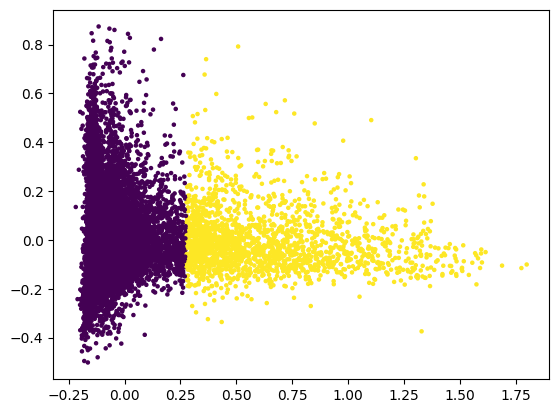

In [9]:
kmeans_tfidf = KMeans(n_clusters=2, max_iter=100, random_state=42).fit(X=tfidf_embeddings_pca)
positive_cluster_center = kmeans_tfidf.cluster_centers_[0]
negative_cluster_center = kmeans_tfidf.cluster_centers_[1]

tfidf_labels = kmeans_tfidf.predict(tfidf_embeddings_pca)
plt.scatter(tfidf_embeddings_pca[:,0], tfidf_embeddings_pca[:,1], c=kmeans_tfidf.labels_, cmap='viridis', s=5)
print(Counter(tfidf_labels))
print(tfidf_labels)
tweets_sentiment_df['sentiment_tfidf_kmeans_pca'] = tfidf_labels

### Agglomerative Clustering

/Users/nitanshjain/.local/share/virtualenvs/Twitter_Data_Analysis-wZ120kVj/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Counter({0: 15535, 1: 2522})
[0 0 0 ... 0 0 0]


/Users/nitanshjain/.local/share/virtualenvs/Twitter_Data_Analysis-wZ120kVj/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Counter({0: 16961, 1: 1096})
[0 0 0 ... 0 0 0]


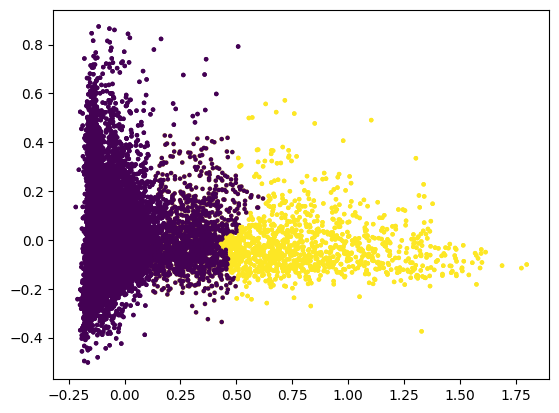

In [10]:
# ward 
agg_ward_tfidf = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
agg_ward_tfidf.fit(X=tfidf_embeddings_pca)
plt.scatter(tfidf_embeddings_pca[:,0], tfidf_embeddings_pca[:,1], c=agg_ward_tfidf.labels_, cmap='viridis', s=5)

tfidf_labels = agg_ward_tfidf.labels_
print(Counter(tfidf_labels))
print(tfidf_labels)
tweets_sentiment_df['sentiment_tfidf_agg_ward_pca'] = tfidf_labels

#complete
agg_complete_tfidf = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
agg_complete_tfidf.fit(X=tfidf_embeddings_pca)
plt.scatter(tfidf_embeddings_pca[:,0], tfidf_embeddings_pca[:,1], c=agg_complete_tfidf.labels_, cmap='viridis', s=5)

tfidf_labels = agg_complete_tfidf.labels_
print(Counter(tfidf_labels))
print(tfidf_labels)
tweets_sentiment_df['sentiment_tfidf_agg_complete_pca'] = tfidf_labels

### Birch Clustering

Counter({0: 15535, 1: 2522})
[0 0 0 ... 0 0 0]


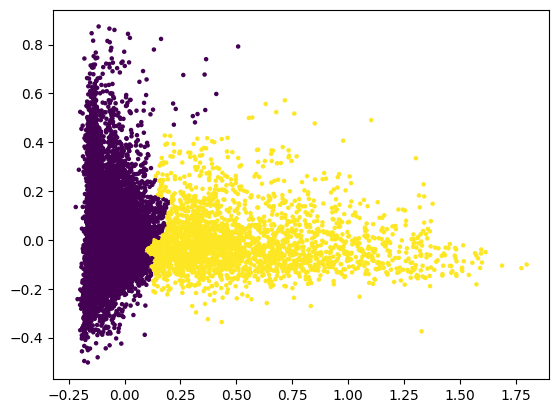

In [11]:
birch_tfidf = Birch(n_clusters=2, threshold=0.000001, branching_factor=5)
birch_tfidf.fit(tfidf_embeddings_pca)
plt.scatter(tfidf_embeddings_pca[:,0], tfidf_embeddings_pca[:,1], c=birch_tfidf.labels_, cmap='viridis', s=5)

tfidf_labels = birch_tfidf.labels_
print(Counter(tfidf_labels))
print(tfidf_labels)
tweets_sentiment_df['sentiment_tfidf_birch_pca'] = tfidf_labels

## NMF Clustering

### KMeans

/Users/nitanshjain/.local/share/virtualenvs/Twitter_Data_Analysis-wZ120kVj/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Counter({0: 16312, 1: 1745})
[0 0 0 ... 0 0 0]


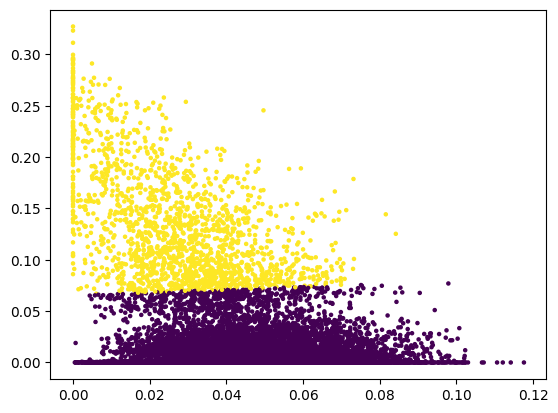

In [12]:
kmeans_tfidf = KMeans(n_clusters=2, max_iter=100, random_state=42).fit(X=tfidf_embeddings_nmf)
positive_cluster_center = kmeans_tfidf.cluster_centers_[0]
negative_cluster_center = kmeans_tfidf.cluster_centers_[1]

tfidf_labels = kmeans_tfidf.predict(tfidf_embeddings_nmf)
plt.scatter(tfidf_embeddings_nmf[:,0], tfidf_embeddings_nmf[:,1], c=kmeans_tfidf.labels_, cmap='viridis', s=5)
print(Counter(tfidf_labels))
print(tfidf_labels)
tweets_sentiment_df['sentiment_tfidf_kmeans_mnf'] = tfidf_labels

### Agglomerative

/Users/nitanshjain/.local/share/virtualenvs/Twitter_Data_Analysis-wZ120kVj/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


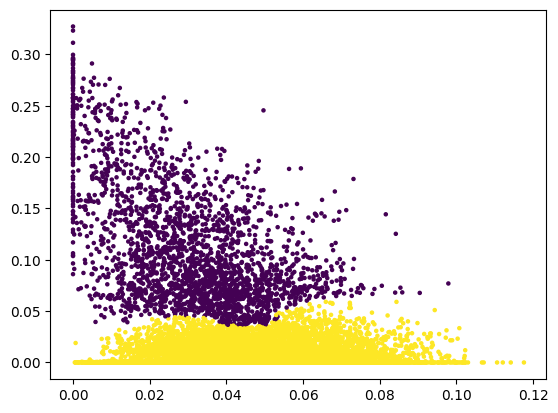

Counter({1: 15594, 0: 2463})
[1 1 1 ... 1 1 1]


/Users/nitanshjain/.local/share/virtualenvs/Twitter_Data_Analysis-wZ120kVj/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


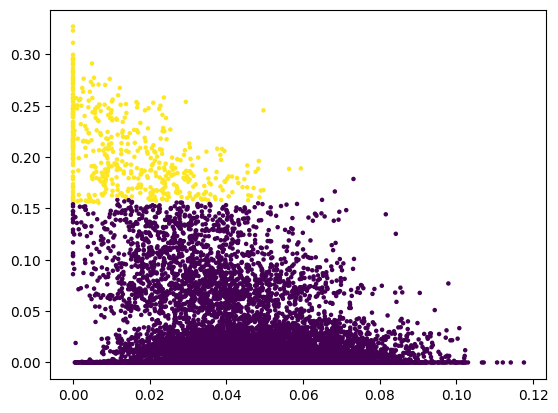

Counter({0: 17569, 1: 488})
[0 0 0 ... 0 0 0]


In [13]:
# ward 
agg_ward_tfidf = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
agg_ward_tfidf.fit(X=tfidf_embeddings_nmf)
plt.scatter(tfidf_embeddings_nmf[:,0], tfidf_embeddings_nmf[:,1], c=agg_ward_tfidf.labels_, cmap='viridis', s=5)
plt.show()
tfidf_labels = agg_ward_tfidf.labels_
print(Counter(tfidf_labels))
print(tfidf_labels)
tweets_sentiment_df['sentiment_tfidf_agg_ward_nmf'] = tfidf_labels

#complete
agg_complete_tfidf = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
agg_complete_tfidf.fit(X=tfidf_embeddings_nmf)
plt.scatter(tfidf_embeddings_nmf[:,0], tfidf_embeddings_nmf[:,1], c=agg_complete_tfidf.labels_, cmap='viridis', s=5)
plt.show()
tfidf_labels = agg_complete_tfidf.labels_
print(Counter(tfidf_labels))
print(tfidf_labels)
tweets_sentiment_df['sentiment_tfidf_agg_complete_nmf'] = tfidf_labels

### Birch Clustering

Counter({1: 15703, 0: 2354})
[1 1 1 ... 1 1 1]


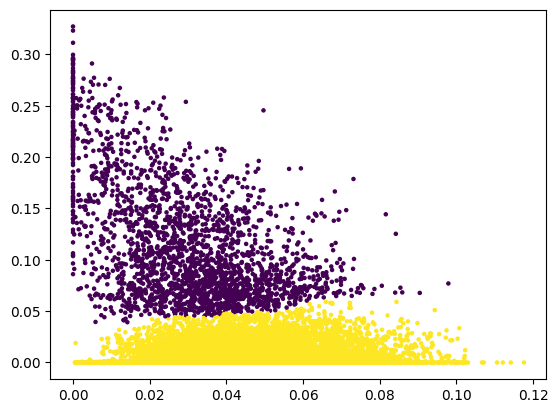

In [14]:
birch_tfidf = Birch(n_clusters=2, threshold=0.00001, branching_factor=50)
birch_tfidf.fit(tfidf_embeddings_nmf)
plt.scatter(tfidf_embeddings_nmf[:,0], tfidf_embeddings_nmf[:,1], c=birch_tfidf.labels_, cmap='viridis', s=5)

tfidf_labels = birch_tfidf.labels_
print(Counter(tfidf_labels))
print(tfidf_labels)
tweets_sentiment_df['sentiment_tfidf_birch_nmf'] = tfidf_labels

# FastText Embeddings

In [16]:
embedding_size = 200
window_size = 5
min_word = 2
down_sampling = 1e-2
tokens = tweets_sentiment_df['tweets_tokens']


fast_text_model = FastText(
                        sample=down_sampling,
                        workers = 4,
                        sg=1
                    )

fast_text_model.build_vocab(tokens)
fast_text_model.train(tokens, total_examples=fast_text_model.corpus_count, epochs=fast_text_model.epochs)

fasttext_embeddings = np.array([np.mean([fast_text_model.wv[word] for word in token], axis=0) for token in tokens])
fasttext_embeddings.shape

# fasttext_embeddings = np.asarray(fasttext_embeddings.todense())
fasttext_embeddings = mm.fit_transform(fasttext_embeddings)

#PCA
# fasttext_embeddings = np.asarray(fasttext_embeddings)
fasttext_embeddings_pca = PCA(n_components=num_components).fit_transform(fasttext_embeddings)
print(fasttext_embeddings_pca.shape)

# #NMF
nmf = NMF(n_components=num_components)
fasttext_embeddings_nmf = nmf.fit_transform(fasttext_embeddings)
print(fasttext_embeddings_nmf.shape)

(18057, 2)
(18057, 2)


/Users/nitanshjain/.local/share/virtualenvs/Twitter_Data_Analysis-wZ120kVj/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


## PCA

### KMeans

/Users/nitanshjain/.local/share/virtualenvs/Twitter_Data_Analysis-wZ120kVj/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Counter({0: 10630, 1: 7427})
[0 0 0 ... 0 0 1]


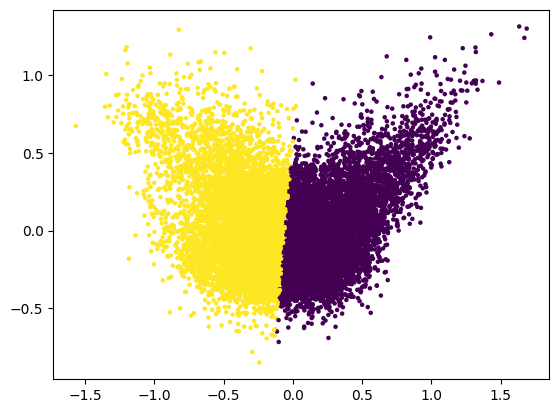

In [17]:
kmeans_fasttext = KMeans(n_clusters=2, max_iter=100, random_state=42).fit(X=fasttext_embeddings_pca)
positive_cluster_center = kmeans_fasttext.cluster_centers_[0]
negative_cluster_center = kmeans_fasttext.cluster_centers_[1]

fasttext_labels = kmeans_fasttext.predict(fasttext_embeddings_pca)
plt.scatter(fasttext_embeddings_pca[:,0], fasttext_embeddings_pca[:,1], c=kmeans_fasttext.labels_, cmap='viridis', s=5)
print(Counter(fasttext_labels))
print(fasttext_labels)
tweets_sentiment_df['sentiment_fasttext_kmeans_pca'] = fasttext_labels

### Agglomerative Clustering

/Users/nitanshjain/.local/share/virtualenvs/Twitter_Data_Analysis-wZ120kVj/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


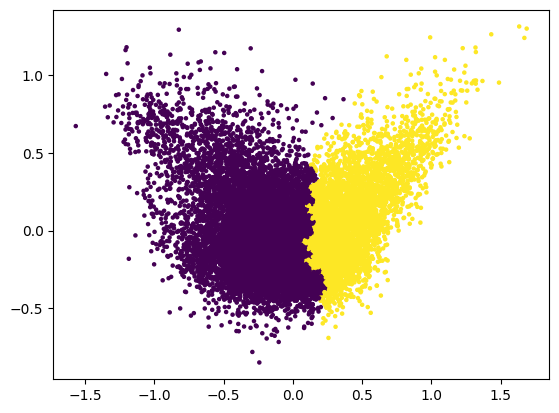

Counter({0: 11419, 1: 6638})
[1 1 0 ... 0 1 0]


/Users/nitanshjain/.local/share/virtualenvs/Twitter_Data_Analysis-wZ120kVj/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


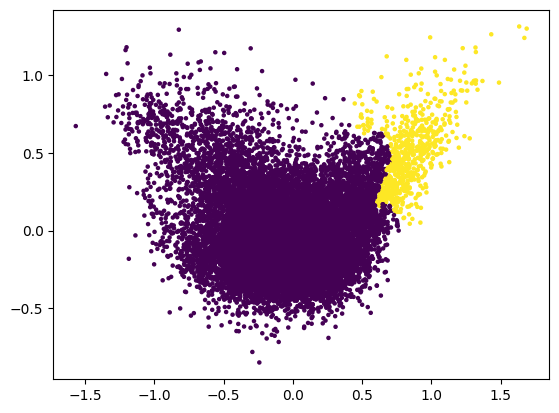

Counter({0: 17388, 1: 669})
[0 0 0 ... 0 0 0]


In [18]:
# ward 
agg_ward_fasttext = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
agg_ward_fasttext.fit(X=fasttext_embeddings_pca)
fasttext_labels = agg_ward_fasttext.labels_
plt.scatter(fasttext_embeddings_pca[:,0], fasttext_embeddings_pca[:,1], c=agg_ward_fasttext.labels_, cmap='viridis', s=5)
plt.show()
print(Counter(fasttext_labels))
print(fasttext_labels)
tweets_sentiment_df['sentiment_fasttext_agg_ward_pca'] = fasttext_labels

# #complete
agg_complete_fasttext = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
agg_complete_fasttext.fit(X=fasttext_embeddings_pca)
fasttext_labels = agg_complete_fasttext.labels_
plt.scatter(fasttext_embeddings_pca[:,0], fasttext_embeddings_pca[:,1], c=agg_complete_fasttext.labels_, cmap='viridis', s=5)
plt.show()
print(Counter(fasttext_labels))
print(fasttext_labels)
tweets_sentiment_df['sentiment_fasttext_agg_complete_pca'] = fasttext_labels

### Birch Clustering

Counter({0: 10778, 1: 7279})
[1 1 0 ... 0 1 0]


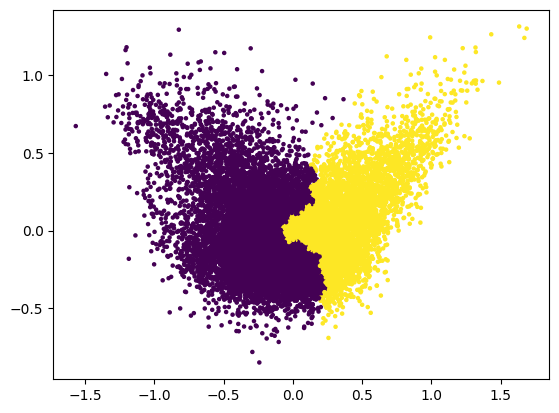

In [23]:
birch_fasttext = Birch(n_clusters=2, threshold=0.00001, branching_factor=50)
birch_fasttext.fit(fasttext_embeddings_pca)
plt.scatter(fasttext_embeddings_pca[:,0], fasttext_embeddings_pca[:,1], c=birch_fasttext.labels_, cmap='viridis', s=5)

fasttext_labels = birch_fasttext.labels_
print(Counter(fasttext_labels))
print(fasttext_labels)
tweets_sentiment_df['sentiment_fasttext_birch_pca'] = fasttext_labels

## NMF

### KMeans

/Users/nitanshjain/.local/share/virtualenvs/Twitter_Data_Analysis-wZ120kVj/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Counter({0: 10190, 1: 7867})
[0 0 0 ... 0 0 1]


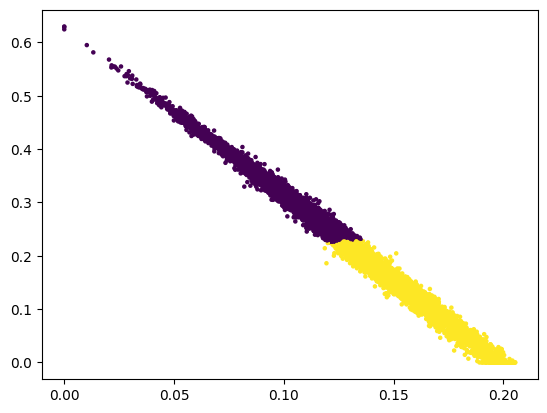

In [21]:
kmeans_fasttext = KMeans(n_clusters=2, max_iter=100, random_state=42).fit(X=fasttext_embeddings_nmf)
positive_cluster_center = kmeans_fasttext.cluster_centers_[0]
negative_cluster_center = kmeans_fasttext.cluster_centers_[1]

fasttext_labels = kmeans_fasttext.predict(fasttext_embeddings_nmf)
plt.scatter(fasttext_embeddings_nmf[:,0], fasttext_embeddings_nmf[:,1], c=kmeans_fasttext.labels_, cmap='viridis', s=5)
print(Counter(fasttext_labels))
print(fasttext_labels)
tweets_sentiment_df['sentiment_fasttext_kmeans_nmf'] = fasttext_labels

### Hierarchical Clustering

/Users/nitanshjain/.local/share/virtualenvs/Twitter_Data_Analysis-wZ120kVj/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


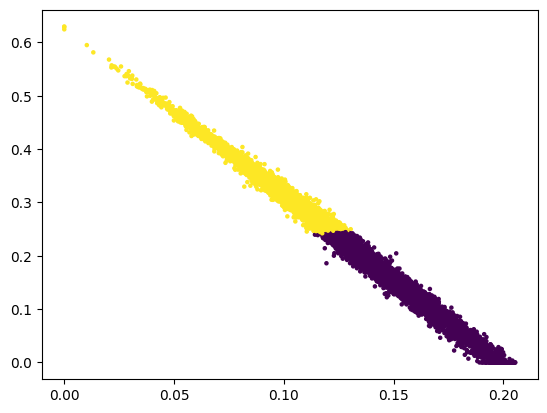

Counter({0: 9317, 1: 8740})
[1 1 1 ... 1 1 0]


/Users/nitanshjain/.local/share/virtualenvs/Twitter_Data_Analysis-wZ120kVj/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


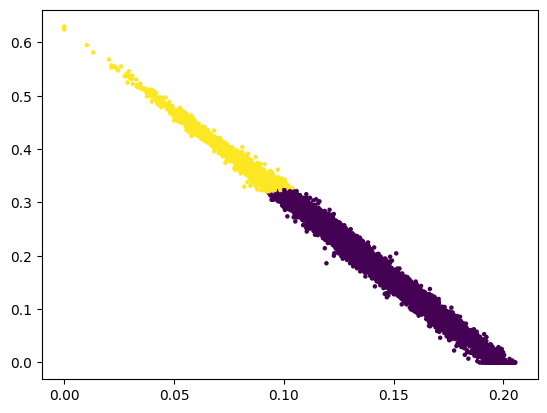

Counter({0: 15218, 1: 2839})
[0 1 0 ... 0 0 0]


In [22]:
# ward 
agg_ward_fasttext = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
agg_ward_fasttext.fit(X=fasttext_embeddings_nmf)
fasttext_labels = agg_ward_fasttext.labels_
plt.scatter(fasttext_embeddings_nmf[:,0], fasttext_embeddings_nmf[:,1], c=agg_ward_fasttext.labels_, cmap='viridis', s=5)
plt.show()
print(Counter(fasttext_labels))
print(fasttext_labels)
tweets_sentiment_df['sentiment_fasttext_agg_ward_nmf'] = fasttext_labels

# #complete
agg_complete_fasttext = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
agg_complete_fasttext.fit(X=fasttext_embeddings_nmf)
fasttext_labels = agg_complete_fasttext.labels_
plt.scatter(fasttext_embeddings_nmf[:,0], fasttext_embeddings_nmf[:,1], c=agg_complete_fasttext.labels_, cmap='viridis', s=5)
plt.show()
print(Counter(fasttext_labels))
print(fasttext_labels)
tweets_sentiment_df['sentiment_fasttext_agg_complete_nmf'] = fasttext_labels

### Birch Clustering

Counter({0: 9322, 1: 8735})
[1 1 1 ... 1 1 0]


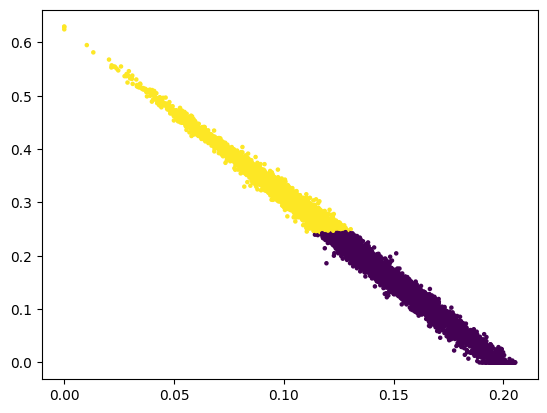

In [25]:
birch_fasttext = Birch(n_clusters=2, threshold=0.00001, branching_factor=50)
birch_fasttext.fit(fasttext_embeddings_nmf)
plt.scatter(fasttext_embeddings_nmf[:,0], fasttext_embeddings_nmf[:,1], c=birch_fasttext.labels_, cmap='viridis', s=5)

fasttext_labels = birch_fasttext.labels_
print(Counter(fasttext_labels))
print(fasttext_labels)
tweets_sentiment_df['sentiment_fasttext_birch_nmf'] = fasttext_labels

# Word2Vec Embeddings

In [26]:
tweets_tokens = tweets_sentiment_df['tweets_tokens']

#Detecting Common Phrases so each word is treated as its own
tweets_phrases = gensim.models.phrases.Phrases(tweets_tokens)
tweets_phraser = gensim.models.phrases.Phraser(tweets_phrases)
tweets_phrase = tweets_phraser[tweets_tokens]

MODEL_TRAIN = gensim.models.word2vec.Word2Vec(sentences=tweets_phrase, workers=2)

def word2vec(tokens, model, text_input):
    embeddings = []
    for row in text_input:
        row_vector = np.zeros(model.vector_size)
        for word in row:
            if word in model.wv.index_to_key:
                word_vector = model.wv[word]
                row_vector += word_vector
        embeddings.append(row_vector)
    return np.array(embeddings)

word2vec_embeddings = word2vec(tweets_phrase, MODEL_TRAIN, tweets_phrase)
word2vec_embeddings.shape

word2vec_embeddings = mm.fit_transform(word2vec_embeddings)

#PCA
# word2vec_embeddings = np.asarray(word2vec_embeddings)
word2vec_embeddings_pca = PCA(n_components=num_components).fit_transform(word2vec_embeddings)
print(word2vec_embeddings_pca.shape)

# #NMF
nmf = NMF(n_components=num_components)
word2vec_embeddings_nmf = nmf.fit_transform(word2vec_embeddings)
print(word2vec_embeddings_nmf.shape)

(18057, 2)
(18057, 2)


## PCA

### KMeans

/Users/nitanshjain/.local/share/virtualenvs/Twitter_Data_Analysis-wZ120kVj/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Counter({0: 10013, 1: 8044})
[1 1 0 ... 1 1 0]


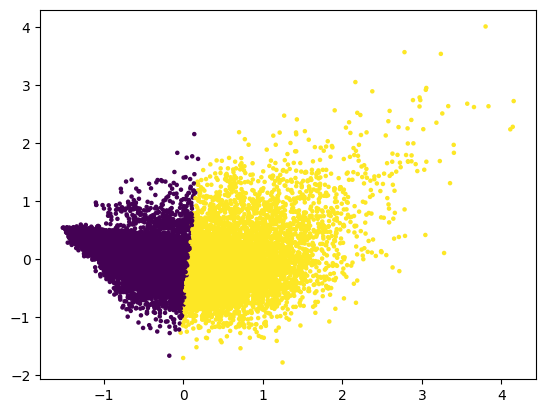

In [27]:
kmeans_word2vec = KMeans(n_clusters=2, max_iter=100, random_state=42).fit(X=word2vec_embeddings_pca)
positive_cluster_center = kmeans_word2vec.cluster_centers_[0]
negative_cluster_center = kmeans_word2vec.cluster_centers_[1]

word2vec_labels = kmeans_word2vec.predict(word2vec_embeddings_pca)
plt.scatter(word2vec_embeddings_pca[:,0], word2vec_embeddings_pca[:,1], c=kmeans_word2vec.labels_, cmap='viridis', s=5)
print(Counter(word2vec_labels))
print(word2vec_labels)
tweets_sentiment_df['sentiment_word2vec_kmeans_pca'] = word2vec_labels

### Agglomerative Clustering

/Users/nitanshjain/.local/share/virtualenvs/Twitter_Data_Analysis-wZ120kVj/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


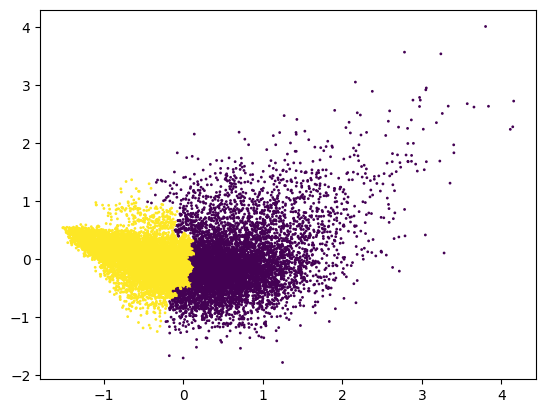

Counter({1: 10002, 0: 8055})
[0 0 1 ... 0 0 1]


/Users/nitanshjain/.local/share/virtualenvs/Twitter_Data_Analysis-wZ120kVj/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


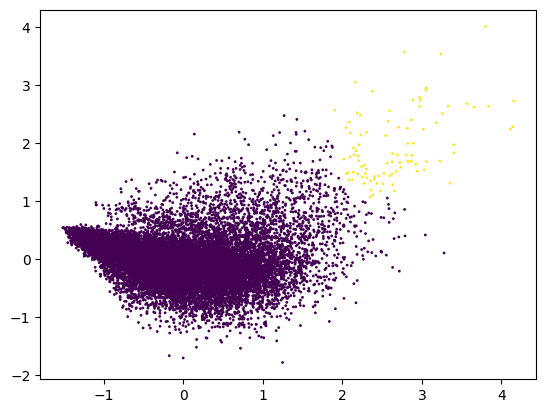

Counter({0: 17964, 1: 93})
[0 0 0 ... 0 0 0]


In [28]:
# ward 
agg_ward_word2vec = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
agg_ward_word2vec.fit(X=word2vec_embeddings_pca)
word2vec_labels = agg_ward_word2vec.labels_
plt.scatter(word2vec_embeddings_pca[:,0], word2vec_embeddings_pca[:,1], c=agg_ward_word2vec.labels_, cmap='viridis', s=1)
plt.show()
print(Counter(word2vec_labels))
print(word2vec_labels)
tweets_sentiment_df['sentiment_word2vec_agg_ward_pca'] = word2vec_labels

#complete
agg_complete_word2vec = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
agg_complete_word2vec.fit(X=word2vec_embeddings_pca)
word2vec_labels = agg_complete_word2vec.labels_
plt.scatter(word2vec_embeddings_pca[:,0], word2vec_embeddings_pca[:,1], c=agg_complete_word2vec.labels_, cmap='viridis', s=1)
plt.show()
print(Counter(word2vec_labels))
print(word2vec_labels)
tweets_sentiment_df['sentiment_word2vec_agg_complete_pca'] = word2vec_labels

### Birch Clustering

Counter({0: 12382, 1: 5675})
[1 1 0 ... 0 1 0]


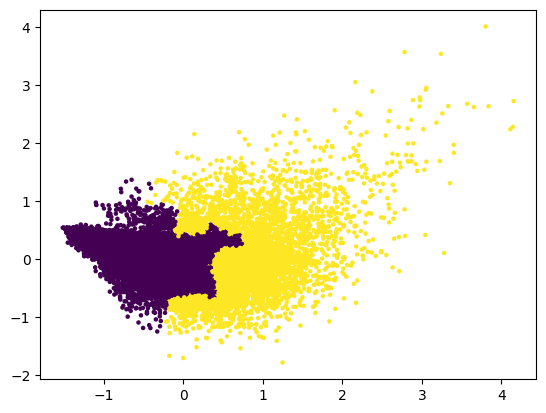

In [34]:
birch_word2vec = Birch(n_clusters=2, threshold=0.00001, branching_factor=50)
birch_word2vec.fit(word2vec_embeddings_pca)
plt.scatter(word2vec_embeddings_pca[:,0], word2vec_embeddings_pca[:,1], c=birch_word2vec.labels_, cmap='viridis', s=5)

word2vec_labels = birch_word2vec.labels_
print(Counter(word2vec_labels))
print(word2vec_labels)
tweets_sentiment_df['sentiment_word2vec_birch_pca'] = word2vec_labels

## NMF

### KMeans

/Users/nitanshjain/.local/share/virtualenvs/Twitter_Data_Analysis-wZ120kVj/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Counter({0: 10015, 1: 8042})
[1 1 0 ... 1 1 0]


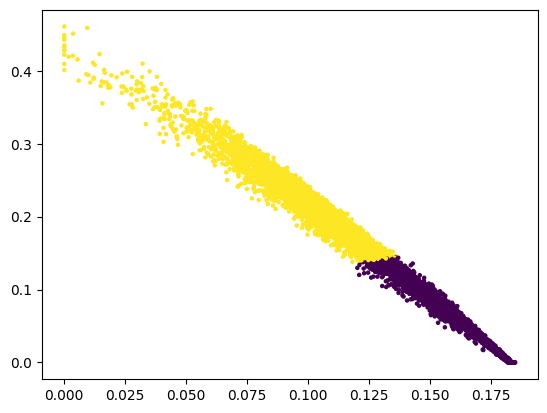

In [35]:
kmeans_word2vec = KMeans(n_clusters=2, max_iter=100, random_state=42).fit(X=word2vec_embeddings_nmf)
positive_cluster_center = kmeans_word2vec.cluster_centers_[0]
negative_cluster_center = kmeans_word2vec.cluster_centers_[1]

word2vec_labels = kmeans_word2vec.predict(word2vec_embeddings_nmf)
plt.scatter(word2vec_embeddings_nmf[:,0], word2vec_embeddings_nmf[:,1], c=kmeans_word2vec.labels_, cmap='viridis', s=5)
print(Counter(word2vec_labels))
print(word2vec_labels)
tweets_sentiment_df['sentiment_word2vec_kmeans_nmf'] = word2vec_labels

### Agglomerative Clustering

/Users/nitanshjain/.local/share/virtualenvs/Twitter_Data_Analysis-wZ120kVj/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


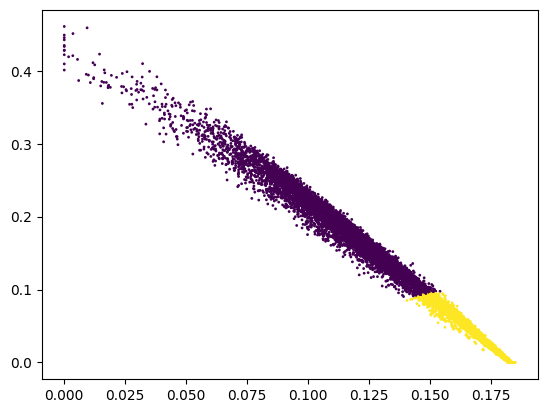

Counter({0: 12588, 1: 5469})
[0 0 0 ... 0 0 1]


/Users/nitanshjain/.local/share/virtualenvs/Twitter_Data_Analysis-wZ120kVj/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


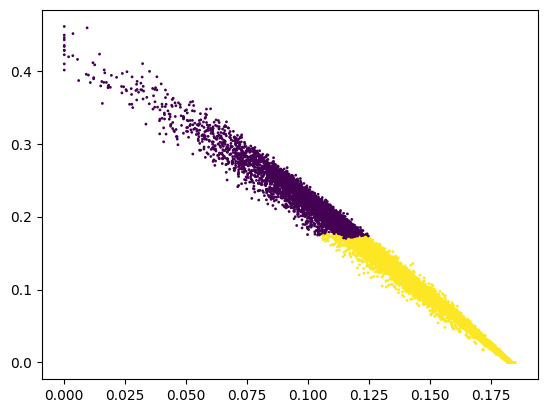

Counter({1: 12744, 0: 5313})
[0 0 1 ... 1 0 1]


In [36]:
# ward 
agg_ward_word2vec = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
agg_ward_word2vec.fit(X=word2vec_embeddings_nmf)
word2vec_labels = agg_ward_word2vec.labels_
plt.scatter(word2vec_embeddings_nmf[:,0], word2vec_embeddings_nmf[:,1], c=agg_ward_word2vec.labels_, cmap='viridis', s=1)
plt.show()
print(Counter(word2vec_labels))
print(word2vec_labels)
tweets_sentiment_df['sentiment_word2vec_agg_ward_nmf'] = word2vec_labels

#complete
agg_complete_word2vec = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
agg_complete_word2vec.fit(X=word2vec_embeddings_nmf)
word2vec_labels = agg_complete_word2vec.labels_
plt.scatter(word2vec_embeddings_nmf[:,0], word2vec_embeddings_nmf[:,1], c=agg_complete_word2vec.labels_, cmap='viridis', s=1)
plt.show()
print(Counter(word2vec_labels))
print(word2vec_labels)
tweets_sentiment_df['sentiment_word2vec_agg_complete_nmf'] = word2vec_labels

### Birch Clustering

Counter({0: 12209, 1: 5848})
[1 1 0 ... 0 1 0]


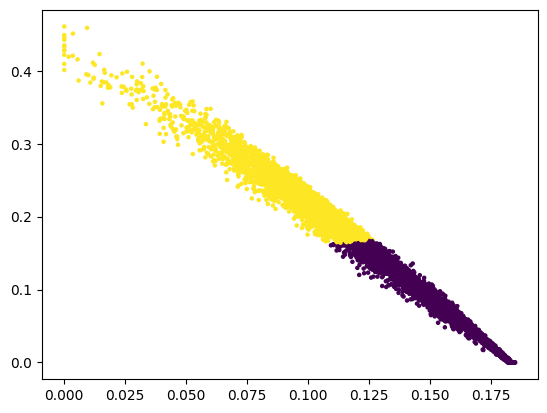

In [37]:
birch_word2vec = Birch(n_clusters=2, threshold=0.00001, branching_factor=50)
birch_word2vec.fit(word2vec_embeddings_nmf)
plt.scatter(word2vec_embeddings_nmf[:,0], word2vec_embeddings_nmf[:,1], c=birch_word2vec.labels_, cmap='viridis', s=5)

word2vec_labels = birch_word2vec.labels_
print(Counter(word2vec_labels))
print(word2vec_labels)
tweets_sentiment_df['sentiment_word2vec_birch_nmf'] = word2vec_labels

# Glove Embeddings

In [38]:
glove = torchtext.vocab.GloVe(name="6B", dim=200, max_vectors=10000)
def split_text(text):
    return text.split()

def get_glove_embeddings(glove_vector, x_train_input):
    train = []
    for line in enumerate(x_train_input):
        text = line[-1]
        vector_sum = sum(glove_vector[w] for w in split_text(text))
        label = torch.tensor(int(line[0] == "4")).long()
        train.append((vector_sum, label))
            
    return train

glove_embeddings = get_glove_embeddings(glove, tweets_sentiment_df['tweet'])
glove_embeddings = np.array([x[0].numpy() for x in glove_embeddings])

glove_embeddings = mm.fit_transform(glove_embeddings)

#PCA
glove_embeddings_pca = PCA(n_components=num_components).fit_transform(glove_embeddings)
print(glove_embeddings_pca.shape)

# #NMF
nmf = NMF(n_components=num_components)
glove_embeddings_nmf = nmf.fit_transform(glove_embeddings)
print(glove_embeddings_nmf.shape)

.vector_cache/glove.6B.zip: 862MB [04:38, 3.09MB/s]                               
100%|█████████▉| 9999/10000 [00:01<00:00, 7437.57it/s]


(18057, 2)
(18057, 2)


/Users/nitanshjain/.local/share/virtualenvs/Twitter_Data_Analysis-wZ120kVj/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


## PCA

### KMeans

/Users/nitanshjain/.local/share/virtualenvs/Twitter_Data_Analysis-wZ120kVj/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Counter({1: 9991, 0: 8066})
[0 0 1 ... 1 0 1]


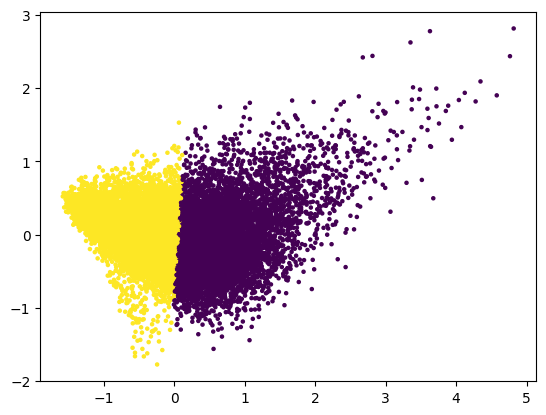

In [39]:
kmeans_glove = KMeans(n_clusters=2, max_iter=100, random_state=42).fit(X=glove_embeddings_pca)
positive_cluster_center = kmeans_glove.cluster_centers_[0]
negative_cluster_center = kmeans_glove.cluster_centers_[1]

glove_labels = kmeans_glove.predict(glove_embeddings_pca)
plt.scatter(glove_embeddings_pca[:,0], glove_embeddings_pca[:,1], c=kmeans_glove.labels_, cmap='viridis', s=5)
print(Counter(glove_labels))
print(glove_labels)
tweets_sentiment_df['sentiment_glove_kmeans_pca'] = glove_labels

### Agglomerative Clustering

/Users/nitanshjain/.local/share/virtualenvs/Twitter_Data_Analysis-wZ120kVj/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


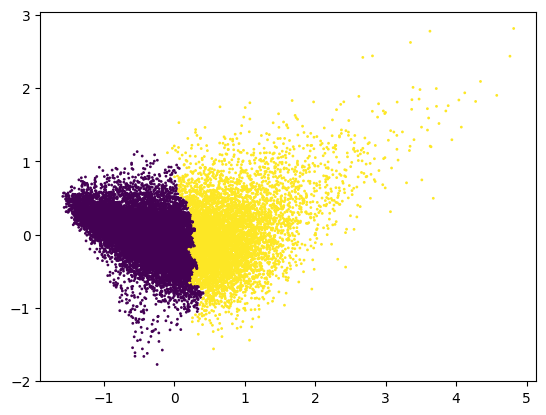

Counter({0: 11762, 1: 6295})
[1 1 0 ... 0 1 0]


/Users/nitanshjain/.local/share/virtualenvs/Twitter_Data_Analysis-wZ120kVj/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


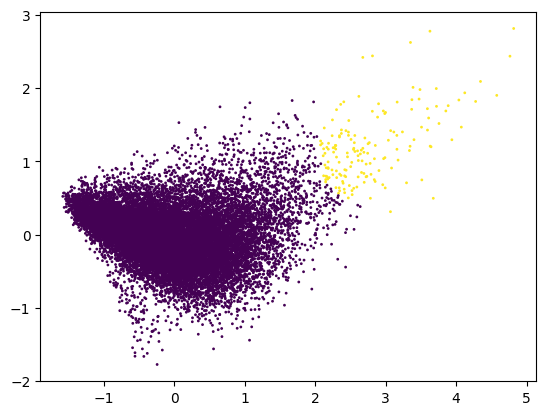

Counter({0: 17896, 1: 161})
[0 0 0 ... 0 0 0]


In [42]:
# ward 
agg_ward_glove = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
agg_ward_glove.fit(X=glove_embeddings_pca)
glove_labels = agg_ward_glove.labels_
plt.scatter(glove_embeddings_pca[:,0], glove_embeddings_pca[:,1], c=agg_ward_glove.labels_, cmap='viridis', s=1)
plt.show()
print(Counter(glove_labels))
print(glove_labels)
tweets_sentiment_df['sentiment_glove_agg_ward_pca'] = glove_labels

#complete
agg_complete_glove = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
agg_complete_glove.fit(X=glove_embeddings_pca)
glove_labels = agg_complete_glove.labels_
plt.scatter(glove_embeddings_pca[:,0], glove_embeddings_pca[:,1], c=agg_complete_glove.labels_, cmap='viridis', s=1)
plt.show()
print(Counter(glove_labels))
print(glove_labels)
tweets_sentiment_df['sentiment_glove_agg_complete_pca'] = glove_labels

### Birch Clustering

Counter({1: 10635, 0: 7422})
[0 0 1 ... 1 0 1]


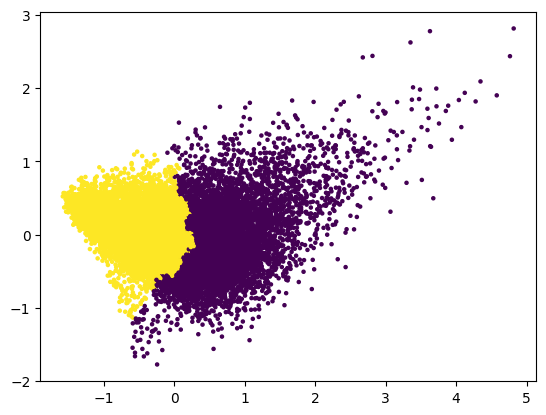

In [43]:
birch_glove = Birch(n_clusters=2, threshold=0.00001, branching_factor=50)
birch_glove.fit(glove_embeddings_pca)
plt.scatter(glove_embeddings_pca[:,0], glove_embeddings_pca[:,1], c=birch_glove.labels_, cmap='viridis', s=5)

glove_labels = birch_glove.labels_
print(Counter(glove_labels))
print(glove_labels)
tweets_sentiment_df['sentiment_glove_birch_pca'] = glove_labels

## NMF

### KMeans

/Users/nitanshjain/.local/share/virtualenvs/Twitter_Data_Analysis-wZ120kVj/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Counter({0: 10174, 1: 7883})
[1 1 0 ... 0 1 0]


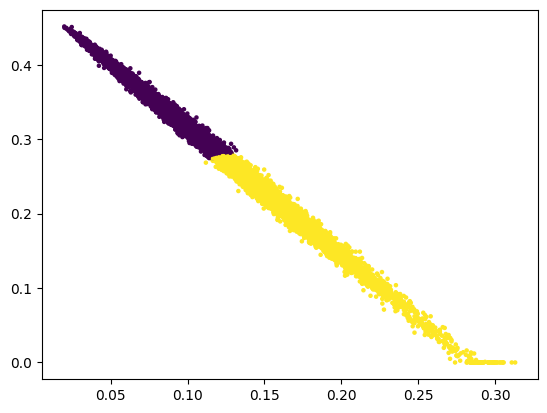

In [44]:
kmeans_glove = KMeans(n_clusters=2, max_iter=100, random_state=42).fit(X=glove_embeddings_nmf)
positive_cluster_center = kmeans_glove.cluster_centers_[0]
negative_cluster_center = kmeans_glove.cluster_centers_[1]

glove_labels = kmeans_glove.predict(glove_embeddings_nmf)
plt.scatter(glove_embeddings_nmf[:,0], glove_embeddings_nmf[:,1], c=kmeans_glove.labels_, cmap='viridis', s=5)
print(Counter(glove_labels))
print(glove_labels)
tweets_sentiment_df['sentiment_glove_kmeans_nmf'] = glove_labels

### Agglomerative Clustering

/Users/nitanshjain/.local/share/virtualenvs/Twitter_Data_Analysis-wZ120kVj/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


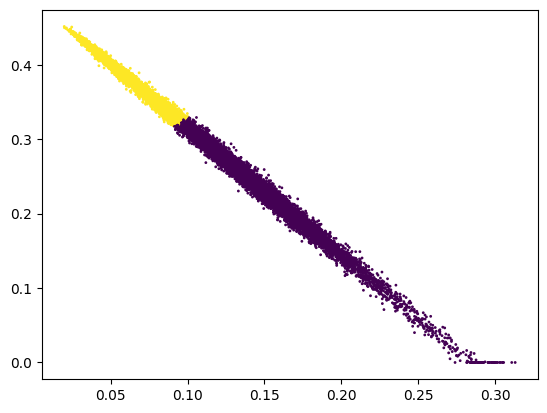

Counter({0: 11920, 1: 6137})
[0 0 0 ... 0 0 1]


/Users/nitanshjain/.local/share/virtualenvs/Twitter_Data_Analysis-wZ120kVj/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


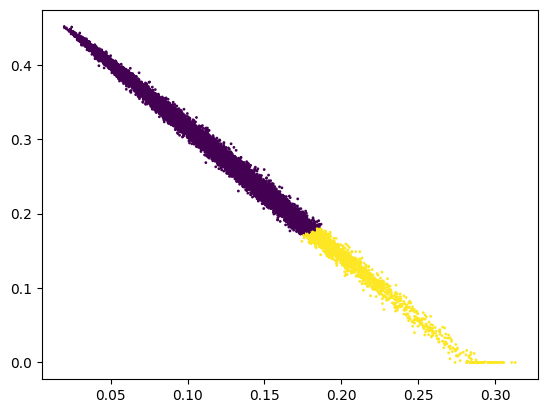

Counter({0: 16487, 1: 1570})
[0 0 0 ... 0 0 0]


In [45]:
# ward 
agg_ward_glove = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
agg_ward_glove.fit(X=glove_embeddings_nmf)
glove_labels = agg_ward_glove.labels_
plt.scatter(glove_embeddings_nmf[:,0], glove_embeddings_nmf[:,1], c=agg_ward_glove.labels_, cmap='viridis', s=1)
plt.show()
print(Counter(glove_labels))
print(glove_labels)
tweets_sentiment_df['sentiment_glove_agg_ward_nmf'] = glove_labels

#complete
agg_complete_glove = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
agg_complete_glove.fit(X=glove_embeddings_nmf)
glove_labels = agg_complete_glove.labels_
plt.scatter(glove_embeddings_nmf[:,0], glove_embeddings_nmf[:,1], c=agg_complete_glove.labels_, cmap='viridis', s=1)
plt.show()
print(Counter(glove_labels))
print(glove_labels)
tweets_sentiment_df['sentiment_glove_agg_complete_nmf'] = glove_labels

### Birch Clustering

Counter({0: 11409, 1: 6648})
[1 1 0 ... 0 1 0]


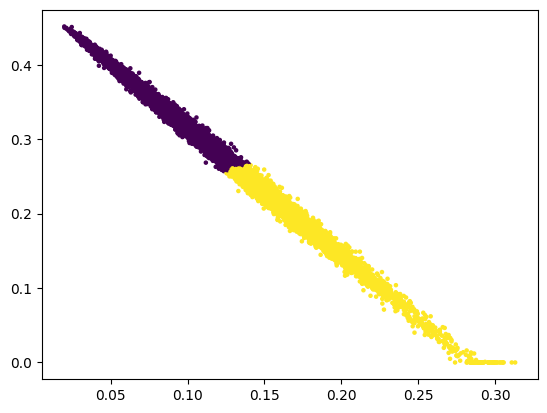

In [46]:
birch_glove = Birch(n_clusters=2, threshold=0.00001, branching_factor=50)
birch_glove.fit(glove_embeddings_nmf)
plt.scatter(glove_embeddings_nmf[:,0], glove_embeddings_nmf[:,1], c=birch_glove.labels_, cmap='viridis', s=5)

glove_labels = birch_glove.labels_
print(Counter(glove_labels))
print(glove_labels)
tweets_sentiment_df['sentiment_glove_birch_nmf'] = glove_labels

# Value Counts

In [ ]:
print(tweets_sentiment_df.sentiment_flair.value_counts())
print(tweets_sentiment_df.sentiment_nltk.value_counts())
print(tweets_sentiment_df.sentiment_flair_glove_embed_kmeans.value_counts())
# print(tweets_sentiment_df.sentiment_flair_document_embed_kmeans.value_counts())
print(tweets_sentiment_df.sentiment_fast_text_embed_kmeans.value_counts())
print(tweets_sentiment_df.sentiment_fast_text_embed_nmf_kmeans.value_counts())

sentiment_flair
-1    9897
 1    8160
Name: count, dtype: int64
sentiment_nltk
-1    9949
 1    8108
Name: count, dtype: int64
sentiment_flair_glove_embed_kmeans
-1    11068
 1     6989
Name: count, dtype: int64
sentiment_fast_text_embed_kmeans
-1    10579
 1     7478
Name: count, dtype: int64
sentiment_fast_text_embed_nmf_kmeans
-1    10239
 1     7818
Name: count, dtype: int64


In [ ]:
pd.DataFrame.to_csv(tweets_sentiment_df, '/Users/nitanshjain/Documents/Projects/Twitter_Data_Analysis/v2/data/tweets_with_sentiment_v2.csv', index=False)

In [ ]:
# https://pub.towardsai.net/sentiment-analysis-without-modeling-textblob-vs-vader-vs-flair-657b7af855f4